### 5.5) Gathering Input Graphs

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 80.7 MB/s eta 0:00:00:00:01:01
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-productivity-rate-graphs"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


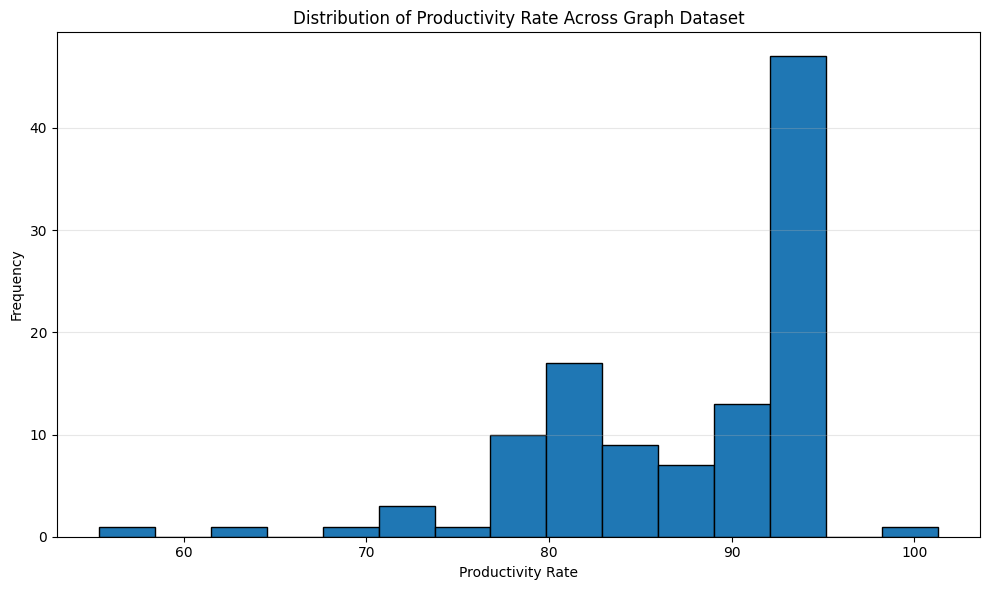

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

rates = []
for graph in graphs:
    if hasattr(graph, 'y'):
        val = graph.y.item() if graph.y.numel() == 1 else float(graph.y[0])
        rates.append(val)

plt.figure(figsize=(10, 6))
plt.hist(rates, bins=15, edgecolor='black')
plt.xlabel("Productivity Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Productivity Rate Across Graph Dataset")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Productivity rate = (Eggs Laid / Number of Hens) x 100.

The majority of days are over 90, which is a high productivity rate. The smallest rate was under 60 one day and the largest was a perfect 100.

In [4]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [5]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 6) Create GAT Model for Graph Regression¶

GAT model takes graph as input, applies GAT layers to learn node embeddings, aggregates (mean pooling or attention pooling) to a graph level embedding, and passes that to fully connected layers to predict a single value (productivity)

global mean pooling

In [11]:
# using edge_attr properly

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATv2Conv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=in_edge_feats)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.mlp(x).squeeze(1)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion, device):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae

# Replace these with your actual data and dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Make sure `graphs_padded` is defined and has x, edge_index, edge_attr, y, batch
# Also make sure all graphs have same node feature dimension and edge feature dimension
in_node_feats = graphs_padded[0].x.shape[1]
in_edge_feats = graphs_padded[0].edge_attr.shape[1]

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=in_node_feats, in_edge_feats=in_edge_feats).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, rmse, mae = eval_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load best model and evaluate on validation set
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pt"))
    _, rmse, mae = eval_model(model, val_loader, criterion, device)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")


Fold 1
Epoch 0 | Train Loss: 1.1058 | Val Loss: 0.6407 | RMSE: 0.8005 | MAE: 0.7449
Epoch 1 | Train Loss: 1.1123 | Val Loss: 0.6330 | RMSE: 0.7956 | MAE: 0.7388
Epoch 2 | Train Loss: 1.1049 | Val Loss: 0.6322 | RMSE: 0.7951 | MAE: 0.7386
Epoch 3 | Train Loss: 1.1067 | Val Loss: 0.6275 | RMSE: 0.7921 | MAE: 0.7344
Epoch 4 | Train Loss: 1.1046 | Val Loss: 0.6226 | RMSE: 0.7890 | MAE: 0.7308
Epoch 5 | Train Loss: 1.0996 | Val Loss: 0.6229 | RMSE: 0.7893 | MAE: 0.7321
Epoch 6 | Train Loss: 1.0867 | Val Loss: 0.6180 | RMSE: 0.7861 | MAE: 0.7291
Epoch 7 | Train Loss: 1.0693 | Val Loss: 0.6173 | RMSE: 0.7857 | MAE: 0.7297
Epoch 8 | Train Loss: 1.0535 | Val Loss: 0.6114 | RMSE: 0.7819 | MAE: 0.7268
Epoch 9 | Train Loss: 1.0162 | Val Loss: 0.5892 | RMSE: 0.7676 | MAE: 0.7104
Epoch 10 | Train Loss: 0.9994 | Val Loss: 0.5649 | RMSE: 0.7516 | MAE: 0.6953
Epoch 11 | Train Loss: 0.9208 | Val Loss: 0.5615 | RMSE: 0.7493 | MAE: 0.6897
Epoch 12 | Train Loss: 0.8515 | Val Loss: 0.5563 | RMSE: 0.7459 | M

global_max_pool instead of global_mean_pool

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, edge_dim, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=edge_dim, add_self_loops=False)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=edge_dim, add_self_loops=False)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = global_max_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae

all_rmse = []
all_mae = []

# Assume edge_attr is consistent across graphs and has fixed dim
edge_dim = graphs_padded[0].edge_attr.shape[1]

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim, edge_dim=edge_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_max_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_max_fold{fold}.pt"))
    _, rmse, mae = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.0835 | Val Loss: 0.6919 | RMSE: 0.8318 | MAE: 0.7806


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0709 | Val Loss: 0.7060 | RMSE: 0.8402 | MAE: 0.7886


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0625 | Val Loss: 0.7216 | RMSE: 0.8495 | MAE: 0.7980


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0553 | Val Loss: 0.7267 | RMSE: 0.8525 | MAE: 0.8028


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0483 | Val Loss: 0.7249 | RMSE: 0.8514 | MAE: 0.8016


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0315 | Val Loss: 0.7397 | RMSE: 0.8601 | MAE: 0.8112


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0164 | Val Loss: 0.7362 | RMSE: 0.8580 | MAE: 0.8083


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 1.0062 | Val Loss: 0.7308 | RMSE: 0.8549 | MAE: 0.8069


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9856 | Val Loss: 0.7313 | RMSE: 0.8551 | MAE: 0.8069


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9635 | Val Loss: 0.7206 | RMSE: 0.8489 | MAE: 0.7996


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9277 | Val Loss: 0.7131 | RMSE: 0.8444 | MAE: 0.7977
Early stopping triggered.
Fold 1 final RMSE: 0.8318, MAE: 0.7806
Fold 2


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1104 | Val Loss: 0.5787 | RMSE: 0.7607 | MAE: 0.7247


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.1061 | Val Loss: 0.5832 | RMSE: 0.7637 | MAE: 0.7276


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0932 | Val Loss: 0.5821 | RMSE: 0.7629 | MAE: 0.7265


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0875 | Val Loss: 0.5765 | RMSE: 0.7593 | MAE: 0.7227


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0774 | Val Loss: 0.5862 | RMSE: 0.7656 | MAE: 0.7282


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0642 | Val Loss: 0.5818 | RMSE: 0.7628 | MAE: 0.7261


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0484 | Val Loss: 0.5728 | RMSE: 0.7568 | MAE: 0.7203


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 1.0249 | Val Loss: 0.5661 | RMSE: 0.7524 | MAE: 0.7160


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9916 | Val Loss: 0.5585 | RMSE: 0.7473 | MAE: 0.7105


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9462 | Val Loss: 0.5365 | RMSE: 0.7325 | MAE: 0.6951


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9050 | Val Loss: 0.5223 | RMSE: 0.7227 | MAE: 0.6867


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.8267 | Val Loss: 0.5205 | RMSE: 0.7214 | MAE: 0.6842


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.7546 | Val Loss: 0.4883 | RMSE: 0.6988 | MAE: 0.6631


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.6580 | Val Loss: 0.5055 | RMSE: 0.7110 | MAE: 0.6656


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.5648 | Val Loss: 0.4642 | RMSE: 0.6813 | MAE: 0.6355


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.4629 | Val Loss: 0.4006 | RMSE: 0.6329 | MAE: 0.5870


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.3708 | Val Loss: 0.4193 | RMSE: 0.6475 | MAE: 0.5704


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.3230 | Val Loss: 0.3829 | RMSE: 0.6188 | MAE: 0.5547


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.2519 | Val Loss: 0.3967 | RMSE: 0.6299 | MAE: 0.5527


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.2271 | Val Loss: 0.4384 | RMSE: 0.6621 | MAE: 0.5959


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.1856 | Val Loss: 0.4523 | RMSE: 0.6725 | MAE: 0.5705


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.1898 | Val Loss: 0.3574 | RMSE: 0.5978 | MAE: 0.5231


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.1776 | Val Loss: 0.3316 | RMSE: 0.5759 | MAE: 0.4931


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.1560 | Val Loss: 0.4809 | RMSE: 0.6935 | MAE: 0.6021


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.1496 | Val Loss: 0.4571 | RMSE: 0.6761 | MAE: 0.5908


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.1363 | Val Loss: 0.3459 | RMSE: 0.5881 | MAE: 0.5424


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.1535 | Val Loss: 0.3562 | RMSE: 0.5968 | MAE: 0.5274


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1277 | Val Loss: 0.3818 | RMSE: 0.6179 | MAE: 0.5487


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.1022 | Val Loss: 0.3877 | RMSE: 0.6227 | MAE: 0.5370


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1002 | Val Loss: 0.3954 | RMSE: 0.6288 | MAE: 0.5702


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1284 | Val Loss: 0.3749 | RMSE: 0.6123 | MAE: 0.5433


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.0996 | Val Loss: 0.4263 | RMSE: 0.6529 | MAE: 0.5783


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1023 | Val Loss: 0.4310 | RMSE: 0.6565 | MAE: 0.5989
Early stopping triggered.
Fold 2 final RMSE: 0.5759, MAE: 0.4931
Fold 3


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 0.8717 | Val Loss: 1.5736 | RMSE: 1.2545 | MAE: 0.9416


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.8613 | Val Loss: 1.5689 | RMSE: 1.2526 | MAE: 0.9362


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.8521 | Val Loss: 1.5721 | RMSE: 1.2538 | MAE: 0.9361


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.8473 | Val Loss: 1.5692 | RMSE: 1.2527 | MAE: 0.9332


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.8391 | Val Loss: 1.5649 | RMSE: 1.2509 | MAE: 0.9276


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.8286 | Val Loss: 1.5644 | RMSE: 1.2508 | MAE: 0.9265


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.8241 | Val Loss: 1.5613 | RMSE: 1.2495 | MAE: 0.9255


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.8172 | Val Loss: 1.5629 | RMSE: 1.2502 | MAE: 0.9245


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.8055 | Val Loss: 1.5551 | RMSE: 1.2470 | MAE: 0.9207


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.7950 | Val Loss: 1.5504 | RMSE: 1.2452 | MAE: 0.9164


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.7825 | Val Loss: 1.5416 | RMSE: 1.2416 | MAE: 0.9123


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.7554 | Val Loss: 1.5263 | RMSE: 1.2355 | MAE: 0.9094


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.7309 | Val Loss: 1.5088 | RMSE: 1.2283 | MAE: 0.9004


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.7055 | Val Loss: 1.5003 | RMSE: 1.2249 | MAE: 0.8989


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.6778 | Val Loss: 1.4749 | RMSE: 1.2145 | MAE: 0.8848


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.6254 | Val Loss: 1.4427 | RMSE: 1.2011 | MAE: 0.8752


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.5715 | Val Loss: 1.4210 | RMSE: 1.1921 | MAE: 0.8611


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.5159 | Val Loss: 1.3771 | RMSE: 1.1735 | MAE: 0.8541


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.4474 | Val Loss: 1.3105 | RMSE: 1.1448 | MAE: 0.8208


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.3688 | Val Loss: 1.2640 | RMSE: 1.1243 | MAE: 0.7953


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.3483 | Val Loss: 1.2087 | RMSE: 1.0994 | MAE: 0.7679


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.2807 | Val Loss: 1.1396 | RMSE: 1.0675 | MAE: 0.7675


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.2471 | Val Loss: 1.1272 | RMSE: 1.0617 | MAE: 0.7326


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.1761 | Val Loss: 1.0445 | RMSE: 1.0220 | MAE: 0.6846


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.1497 | Val Loss: 1.0816 | RMSE: 1.0400 | MAE: 0.7238


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.1348 | Val Loss: 1.0485 | RMSE: 1.0240 | MAE: 0.7102


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.1090 | Val Loss: 1.0405 | RMSE: 1.0201 | MAE: 0.7035


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1133 | Val Loss: 1.0689 | RMSE: 1.0339 | MAE: 0.7318


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.0878 | Val Loss: 1.0032 | RMSE: 1.0016 | MAE: 0.6459


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.0974 | Val Loss: 1.0120 | RMSE: 1.0060 | MAE: 0.6777


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.0739 | Val Loss: 1.0217 | RMSE: 1.0108 | MAE: 0.7010


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.0740 | Val Loss: 1.0273 | RMSE: 1.0136 | MAE: 0.6746


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.0741 | Val Loss: 1.0183 | RMSE: 1.0091 | MAE: 0.6983


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.0625 | Val Loss: 0.9807 | RMSE: 0.9903 | MAE: 0.6648


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.0623 | Val Loss: 1.0264 | RMSE: 1.0131 | MAE: 0.6771


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.0547 | Val Loss: 1.0444 | RMSE: 1.0220 | MAE: 0.7074


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.0446 | Val Loss: 1.0127 | RMSE: 1.0064 | MAE: 0.6795


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.0492 | Val Loss: 1.0418 | RMSE: 1.0207 | MAE: 0.7095


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.0548 | Val Loss: 1.0306 | RMSE: 1.0152 | MAE: 0.7072


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.0364 | Val Loss: 1.0060 | RMSE: 1.0030 | MAE: 0.7007


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.0330 | Val Loss: 1.0450 | RMSE: 1.0223 | MAE: 0.7131


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 41 | Train Loss: 0.0317 | Val Loss: 1.0423 | RMSE: 1.0209 | MAE: 0.6942


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 42 | Train Loss: 0.0307 | Val Loss: 1.0135 | RMSE: 1.0067 | MAE: 0.7005


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 43 | Train Loss: 0.0390 | Val Loss: 0.9917 | RMSE: 0.9958 | MAE: 0.6744
Early stopping triggered.
Fold 3 final RMSE: 0.9903, MAE: 0.6648
Fold 4


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 0.9988 | Val Loss: 1.0904 | RMSE: 1.0442 | MAE: 0.9008


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.9867 | Val Loss: 1.0878 | RMSE: 1.0430 | MAE: 0.9020


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.9826 | Val Loss: 1.0810 | RMSE: 1.0397 | MAE: 0.8991


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.9747 | Val Loss: 1.0820 | RMSE: 1.0402 | MAE: 0.9011


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.9717 | Val Loss: 1.0780 | RMSE: 1.0383 | MAE: 0.9003


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.9656 | Val Loss: 1.0733 | RMSE: 1.0360 | MAE: 0.9007


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.9497 | Val Loss: 1.0759 | RMSE: 1.0372 | MAE: 0.8990


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9352 | Val Loss: 1.0725 | RMSE: 1.0356 | MAE: 0.8989


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9251 | Val Loss: 1.0600 | RMSE: 1.0296 | MAE: 0.8921


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9053 | Val Loss: 1.0697 | RMSE: 1.0343 | MAE: 0.8952


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.8736 | Val Loss: 1.0672 | RMSE: 1.0330 | MAE: 0.8914


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.8538 | Val Loss: 1.0513 | RMSE: 1.0253 | MAE: 0.8840


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.8211 | Val Loss: 1.0358 | RMSE: 1.0178 | MAE: 0.8800


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.7890 | Val Loss: 1.0285 | RMSE: 1.0141 | MAE: 0.8687


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.7491 | Val Loss: 1.0157 | RMSE: 1.0078 | MAE: 0.8622


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.6855 | Val Loss: 0.9796 | RMSE: 0.9898 | MAE: 0.8493


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.6360 | Val Loss: 0.9474 | RMSE: 0.9734 | MAE: 0.8309


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.5841 | Val Loss: 0.9238 | RMSE: 0.9611 | MAE: 0.8162


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.5222 | Val Loss: 0.8860 | RMSE: 0.9413 | MAE: 0.8046


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.4463 | Val Loss: 0.8453 | RMSE: 0.9194 | MAE: 0.7689


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.3805 | Val Loss: 0.8409 | RMSE: 0.9170 | MAE: 0.7762


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.3311 | Val Loss: 0.7803 | RMSE: 0.8833 | MAE: 0.7310


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.2792 | Val Loss: 0.7322 | RMSE: 0.8557 | MAE: 0.7254


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.2585 | Val Loss: 0.7541 | RMSE: 0.8684 | MAE: 0.7502


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2641 | Val Loss: 0.7637 | RMSE: 0.8739 | MAE: 0.7314


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2324 | Val Loss: 0.7145 | RMSE: 0.8453 | MAE: 0.6846


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.2098 | Val Loss: 0.6924 | RMSE: 0.8321 | MAE: 0.6970


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1729 | Val Loss: 0.6451 | RMSE: 0.8032 | MAE: 0.6622


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.1650 | Val Loss: 0.7241 | RMSE: 0.8510 | MAE: 0.6986


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1829 | Val Loss: 0.7230 | RMSE: 0.8503 | MAE: 0.7196


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1724 | Val Loss: 0.6989 | RMSE: 0.8360 | MAE: 0.6943


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1307 | Val Loss: 0.6818 | RMSE: 0.8257 | MAE: 0.6934


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1514 | Val Loss: 0.6702 | RMSE: 0.8186 | MAE: 0.6807


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1054 | Val Loss: 0.6820 | RMSE: 0.8258 | MAE: 0.6765


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1316 | Val Loss: 0.6946 | RMSE: 0.8334 | MAE: 0.6915


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.0909 | Val Loss: 0.6887 | RMSE: 0.8299 | MAE: 0.6928


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.1022 | Val Loss: 0.6689 | RMSE: 0.8179 | MAE: 0.6736


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.0909 | Val Loss: 0.7175 | RMSE: 0.8471 | MAE: 0.6947
Early stopping triggered.
Fold 4 final RMSE: 0.8032, MAE: 0.6622
Fold 5


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.0174 | Val Loss: 1.0514 | RMSE: 1.0254 | MAE: 0.8687


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.9884 | Val Loss: 1.0807 | RMSE: 1.0396 | MAE: 0.8783


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.9691 | Val Loss: 1.1004 | RMSE: 1.0490 | MAE: 0.8845


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.9557 | Val Loss: 1.1136 | RMSE: 1.0553 | MAE: 0.8887


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.9469 | Val Loss: 1.1358 | RMSE: 1.0657 | MAE: 0.8955


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.9328 | Val Loss: 1.1465 | RMSE: 1.0708 | MAE: 0.8981


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.9238 | Val Loss: 1.1460 | RMSE: 1.0705 | MAE: 0.8963


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9142 | Val Loss: 1.1543 | RMSE: 1.0744 | MAE: 0.8983


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.8945 | Val Loss: 1.1667 | RMSE: 1.0801 | MAE: 0.9012


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.8770 | Val Loss: 1.1610 | RMSE: 1.0775 | MAE: 0.8967


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.8525 | Val Loss: 1.1731 | RMSE: 1.0831 | MAE: 0.8969
Early stopping triggered.
Fold 5 final RMSE: 1.0254, MAE: 0.8687

Average RMSE: 0.8453 ± 0.1600
Average MAE: 0.6939 ± 0.1267


Use now globalAttention

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, edge_feat_dim, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)
        
        self.att_pool = GlobalAttention(gate_nn=torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        ))
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Optional: concatenate edge_attr info into node features or apply custom logic
        # Currently unused because GATConv does not support edge_attr directly

        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim, edge_feat_dim=max_edge_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_ga_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_ga_fold{fold}.pt"))
    _, rmse, mae = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0664 | Val Loss: 0.7580 | RMSE: 0.8706 | MAE: 0.8221
Epoch 1 | Train Loss: 1.0574 | Val Loss: 0.7522 | RMSE: 0.8673 | MAE: 0.8192
Epoch 2 | Train Loss: 1.0307 | Val Loss: 0.7331 | RMSE: 0.8562 | MAE: 0.8093
Epoch 3 | Train Loss: 0.9615 | Val Loss: 0.6572 | RMSE: 0.8107 | MAE: 0.7651
Epoch 4 | Train Loss: 0.8377 | Val Loss: 0.5105 | RMSE: 0.7145 | MAE: 0.6648
Epoch 5 | Train Loss: 0.6858 | Val Loss: 0.3551 | RMSE: 0.5959 | MAE: 0.5230
Epoch 6 | Train Loss: 0.5189 | Val Loss: 0.2659 | RMSE: 0.5157 | MAE: 0.4681
Epoch 7 | Train Loss: 0.4044 | Val Loss: 0.1962 | RMSE: 0.4430 | MAE: 0.3661
Epoch 8 | Train Loss: 0.3519 | Val Loss: 0.1937 | RMSE: 0.4402 | MAE: 0.3667
Epoch 9 | Train Loss: 0.3321 | Val Loss: 0.1747 | RMSE: 0.4180 | MAE: 0.3251
Epoch 10 | Train Loss: 0.3308 | Val Loss: 0.1724 | RMSE: 0.4152 | MAE: 0.3000
Epoch 11 | Train Loss: 0.3171 | Val Loss: 0.1739 | RMSE: 0.4170 | MAE: 0.3046
Epoch 12 | Train Loss: 0.3170 | Val Loss: 0.1760 | RMSE: 0.4195 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.1070 | Val Loss: 0.6033 | RMSE: 0.7767 | MAE: 0.7379
Epoch 1 | Train Loss: 1.0982 | Val Loss: 0.5870 | RMSE: 0.7661 | MAE: 0.7284
Epoch 2 | Train Loss: 1.0753 | Val Loss: 0.5502 | RMSE: 0.7417 | MAE: 0.7062
Epoch 3 | Train Loss: 1.0101 | Val Loss: 0.4909 | RMSE: 0.7007 | MAE: 0.6656
Epoch 4 | Train Loss: 0.8767 | Val Loss: 0.3752 | RMSE: 0.6125 | MAE: 0.5788
Epoch 5 | Train Loss: 0.7120 | Val Loss: 0.2781 | RMSE: 0.5273 | MAE: 0.4844
Epoch 6 | Train Loss: 0.5225 | Val Loss: 0.2041 | RMSE: 0.4518 | MAE: 0.4057
Epoch 7 | Train Loss: 0.3797 | Val Loss: 0.2300 | RMSE: 0.4796 | MAE: 0.3811
Epoch 8 | Train Loss: 0.3224 | Val Loss: 0.2355 | RMSE: 0.4853 | MAE: 0.3367
Epoch 9 | Train Loss: 0.3087 | Val Loss: 0.2548 | RMSE: 0.5048 | MAE: 0.3427
Epoch 10 | Train Loss: 0.3000 | Val Loss: 0.2720 | RMSE: 0.5215 | MAE: 0.3460
Epoch 11 | Train Loss: 0.2986 | Val Loss: 0.2636 | RMSE: 0.5135 | MAE: 0.3333
Epoch 12 | Train Loss: 0.2936 | Val Loss: 0.2779 | RMSE: 0.5271 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.8640 | Val Loss: 1.5688 | RMSE: 1.2525 | MAE: 0.9326
Epoch 1 | Train Loss: 0.8559 | Val Loss: 1.5576 | RMSE: 1.2480 | MAE: 0.9248
Epoch 2 | Train Loss: 0.8388 | Val Loss: 1.5296 | RMSE: 1.2368 | MAE: 0.9113
Epoch 3 | Train Loss: 0.8019 | Val Loss: 1.4718 | RMSE: 1.2132 | MAE: 0.8830
Epoch 4 | Train Loss: 0.7195 | Val Loss: 1.3286 | RMSE: 1.1527 | MAE: 0.8097
Epoch 5 | Train Loss: 0.5638 | Val Loss: 1.1175 | RMSE: 1.0571 | MAE: 0.6932
Epoch 6 | Train Loss: 0.4048 | Val Loss: 0.9432 | RMSE: 0.9712 | MAE: 0.6086
Epoch 7 | Train Loss: 0.2928 | Val Loss: 0.8137 | RMSE: 0.9020 | MAE: 0.5246
Epoch 8 | Train Loss: 0.2397 | Val Loss: 0.7590 | RMSE: 0.8712 | MAE: 0.4880
Epoch 9 | Train Loss: 0.2174 | Val Loss: 0.7399 | RMSE: 0.8602 | MAE: 0.5237
Epoch 10 | Train Loss: 0.2099 | Val Loss: 0.7138 | RMSE: 0.8449 | MAE: 0.5078
Epoch 11 | Train Loss: 0.2097 | Val Loss: 0.7091 | RMSE: 0.8421 | MAE: 0.5162
Epoch 12 | Train Loss: 0.1995 | Val Loss: 0.6951 | RMSE: 0.8337 | MAE: 0.5

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.9895 | Val Loss: 1.0387 | RMSE: 1.0192 | MAE: 0.9011
Epoch 1 | Train Loss: 0.9832 | Val Loss: 1.0381 | RMSE: 1.0189 | MAE: 0.8963
Epoch 2 | Train Loss: 0.9623 | Val Loss: 1.0109 | RMSE: 1.0054 | MAE: 0.8832
Epoch 3 | Train Loss: 0.9039 | Val Loss: 0.9202 | RMSE: 0.9593 | MAE: 0.8402
Epoch 4 | Train Loss: 0.7818 | Val Loss: 0.7170 | RMSE: 0.8467 | MAE: 0.7476
Epoch 5 | Train Loss: 0.6250 | Val Loss: 0.5301 | RMSE: 0.7281 | MAE: 0.6345
Epoch 6 | Train Loss: 0.4633 | Val Loss: 0.4198 | RMSE: 0.6479 | MAE: 0.5364
Epoch 7 | Train Loss: 0.3689 | Val Loss: 0.3437 | RMSE: 0.5863 | MAE: 0.4487
Epoch 8 | Train Loss: 0.3188 | Val Loss: 0.2655 | RMSE: 0.5153 | MAE: 0.3727
Epoch 9 | Train Loss: 0.3023 | Val Loss: 0.2424 | RMSE: 0.4923 | MAE: 0.3574
Epoch 10 | Train Loss: 0.2929 | Val Loss: 0.2461 | RMSE: 0.4961 | MAE: 0.3523
Epoch 11 | Train Loss: 0.2910 | Val Loss: 0.2331 | RMSE: 0.4828 | MAE: 0.3456
Epoch 12 | Train Loss: 0.2846 | Val Loss: 0.2963 | RMSE: 0.5443 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.9572 | Val Loss: 1.2225 | RMSE: 1.1057 | MAE: 0.9179
Epoch 1 | Train Loss: 0.9503 | Val Loss: 1.2125 | RMSE: 1.1012 | MAE: 0.9140
Epoch 2 | Train Loss: 0.9413 | Val Loss: 1.2106 | RMSE: 1.1003 | MAE: 0.9092
Epoch 3 | Train Loss: 0.9176 | Val Loss: 1.1739 | RMSE: 1.0835 | MAE: 0.8886
Epoch 4 | Train Loss: 0.8646 | Val Loss: 1.0834 | RMSE: 1.0408 | MAE: 0.8387
Epoch 5 | Train Loss: 0.7483 | Val Loss: 0.8713 | RMSE: 0.9334 | MAE: 0.7314
Epoch 6 | Train Loss: 0.6145 | Val Loss: 0.7090 | RMSE: 0.8420 | MAE: 0.6240
Epoch 7 | Train Loss: 0.5048 | Val Loss: 0.5113 | RMSE: 0.7150 | MAE: 0.4951
Epoch 8 | Train Loss: 0.4100 | Val Loss: 0.3932 | RMSE: 0.6270 | MAE: 0.3838
Epoch 9 | Train Loss: 0.3659 | Val Loss: 0.3178 | RMSE: 0.5637 | MAE: 0.3245
Epoch 10 | Train Loss: 0.3400 | Val Loss: 0.2902 | RMSE: 0.5387 | MAE: 0.3108
Epoch 11 | Train Loss: 0.3233 | Val Loss: 0.2678 | RMSE: 0.5175 | MAE: 0.2927
Epoch 12 | Train Loss: 0.3198 | Val Loss: 0.2708 | RMSE: 0.5204 | MAE: 0.3

### 7) Evaluate

In [9]:
import pandas as pd

target = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
eggs_per_day_df = target[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity rate"})
eggs_per_day_df['productivity rate'] = eggs_per_day_df['productivity rate'].str.replace(',', '.').astype(float)
eggs_per_day_df.head(5)

,date,productivity rate
0,2017-02-27,94.960274
1,2017-03-01,94.260145
2,2017-04-25,92.655367
3,2017-07-12,89.730444
4,2017-07-22,88.271474


In [10]:
mean_eggs = eggs_per_day_df["productivity rate"].mean()
std_eggs = eggs_per_day_df["productivity rate"].std()

print(f"Mean productivity rate: {mean_eggs:.2f}")
print(f"Standard deviation of productivity rate: {std_eggs:.2f}")

Mean productivity rate: 87.16
Standard deviation of productivity rate: 8.34


### Model Evaluation: Egg Productivity Prediction

#### Baseline Statistics
- **Mean productivity rate**: 87.16  
- **Standard deviation**: 8.34  

---

#### Model 1: Global Mean Pooling
- **Average RMSE**: 0.8905 ± 0.3084  
- **Average MAE**: 0.7193 ± 0.2433  
- **Analysis**:  
  Highest error among all models. The high MAE and RMSE suggest that mean pooling fails to capture meaningful variation between nodes, likely due to oversimplification of node-level features.

---

#### Model 2: Global Max Pooling
- **Average RMSE**: 0.8453 ± 0.1600  
- **Average MAE**: 0.6939 ± 0.1267  
- **Analysis**:  
  Slight improvement over mean pooling, particularly in RMSE. Max pooling may help highlight dominant node signals, but still shows weak overall performance.

---

#### Model 3: Global Attention Pooling
- **Average RMSE**: 0.4838 ± 0.0784  
- **Average MAE**: 0.3557 ± 0.0505  
- **Analysis**:  
  Best performance overall. The attention mechanism helps the model focus on the most relevant nodes, improving accuracy and reducing error. MAE (0.3557) is roughly 1/23rd of the standard deviation, indicating strong predictive performance relative to data variability.

---

#### Overall Insights
- Switching from mean or max pooling to attention pooling substantially reduced prediction error.  
- Attention pooling outperformed both mean and max in terms of both RMSE and MAE.  
- The lower standard deviation in model 3's error metrics suggests more consistent predictions across samples.
- The MAE (0.3557) of attention pooling is roughly **1/23rd** of the standard deviation, indicating a strong predictive performance relative to data variability.